In [3]:
import os
import cv2
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


In [2]:
from SqueezeDetHelpers import get_all_points_from_prediction
from Models.PoolingAndFire import create_loss_function_multiple_detection
from PreProcess import *

In [3]:
#MODEL_FILE = os.path.expanduser("~/results/SqueezeDet/all_points_multi_gpu.h5py")
MODEL_FILE = os.path.expanduser("~/results/SqueezeDet/all_points.h5py")
#MODEL_FILE = os.path.expanduser("~/results/SqueezeDet/all_points_overfit_sample0.h5py")
RHD_ANNOTATIONS_FILE = os.path.expanduser("~/datasets/RHD/RHD_published_v2/training/anno_training.pickle")
VALIDATION_DIR = os.path.expanduser("~/datasets/RHD/processed/validation")
TRAIN_DIR = os.path.expanduser("~/datasets/RHD/processed/train")
VALIDATION_ANNOTATIONS = os.path.expanduser("~/datasets/RHD/processed/validation/annotations/")
TRAIN_ANNOTATIONS = os.path.expanduser("~/datasets/RHD/processed/train/annotations/")

In [4]:
create_rhd_annotations(RHD_ANNOTATIONS_FILE,
                       VALIDATION_ANNOTATIONS,
                       VALIDATION_DIR,
                       fingers='ALL',
                       hands_to_annotate='BOTH',
                       annotate_non_visible=False,
                       force_new_files=True)

 15%|█▍        | 531/3561 [00:00<00:00, 5301.13it/s]

Creating annotations in directory: /home/clh/datasets/RHD/processed/validation
Using annotation file: /home/clh/datasets/RHD/RHD_published_v2/training/anno_training.pickle
And outputting to: /home/clh/datasets/RHD/processed/validation/annotations/


100%|██████████| 3561/3561 [00:00<00:00, 5165.55it/s]

In [5]:
BATCHSIZE = 64
EPSILON = 1e-16

LABEL_WEIGHT = 1.0
OFFSET_LOSS_WEIGHT = 1.0
OFFSET_SCALE = int(320 / 20) / 2

NUM_CLASSES = 42

l = create_loss_function_multiple_detection(20,
                                            20,
                                            LABEL_WEIGHT,
                                            OFFSET_SCALE,
                                            OFFSET_LOSS_WEIGHT,
                                            NUM_CLASSES,
                                            EPSILON,
                                            BATCHSIZE)

In [6]:
model = load_model(MODEL_FILE, custom_objects={'loss_function': l})

In [7]:
NUM_SAMPLES_TO_CHECK = 10

samples_to_check = []
for fi in os.listdir(VALIDATION_DIR):
    if fi.endswith('png'):
        samples_to_check.append(int(fi.split('.')[0]))
        if len(samples_to_check) >= NUM_SAMPLES_TO_CHECK:
            break

print(samples_to_check)

[39255, 37303, 37656, 37244, 40921, 37184, 39166, 38639, 37728, 38312]


In [8]:
#labels, images = load_data_with_anchors(samples_to_check,
#                                        DATA_DIR,
#                                        ANNOTATIONS_PATH,
#                                        320, 320,
#                                        20, 20,
#                                        'png',
#                                        num_classes=NUM_CLASSES)

#overfit_sample = [0]
#samples_to_check = overfit_sample
labels, images = load_data_with_anchors(samples_to_check,
                                        VALIDATION_DIR,
                                        VALIDATION_ANNOTATIONS,
                                        320, 320,
                                        20, 20,
                                        OFFSET_SCALE,
                                        'png',
                                        num_classes=NUM_CLASSES,
                                        greyscale=True)

images_show = np.zeros((len(images), 320, 320, 3), dtype=np.uint8)
for c, im in enumerate(images):
    #images_show[c] = cv2.cvtColor((im * 255.0).astype(np.uint8), cv2.COLOR_BGR2RGB)
    images_show[c][:, :, 0] = im.reshape(320, 320) * 255.0
    images_show[c][:, :, 1] = im.reshape(320, 320) * 255.0
    images_show[c][:, :, 2] = im.reshape(320, 320) * 255.0

print(np.max(images[0]))

0.5607843137254902


In [9]:

for l in labels:
    print(l.shape)
    for i in range(NUM_CLASSES):
        offset_xs = l[:, :, NUM_CLASSES+i*2]
        offset_ys = l[:, :, NUM_CLASSES+1+i*2]
        
        print(f"Offset max x: {np.max(offset_xs)}")
        print(f"Offset max y: {np.max(offset_ys)}")
        print("")

(20, 20, 126)
Offset max x: 2.4875001907348633
Offset max y: 1.4125003814697266

Offset max x: 1.3125
Offset max y: 2.2250003814697266

Offset max x: 1.75
Offset max y: 2.6875

Offset max x: 2.4125003814697266
Offset max y: 1.0625

Offset max x: 1.6625003814697266
Offset max y: 1.2000007629394531

Offset max x: 1.776249885559082
Offset max y: 1.0375003814697266

Offset max x: 1.9399995803833008
Offset max y: 1.125

Offset max x: 2.0437498092651367
Offset max y: 1.0499992370605469

Offset max x: 2.4300003051757812
Offset max y: 1.7625007629394531

Offset max x: 1.8524999618530273
Offset max y: 2.112499237060547

Offset max x: 2.2312498092651367
Offset max y: 1.7625007629394531

Offset max x: 2.6337499618530273
Offset max y: 1.5499992370605469

Offset max x: 1.2837495803833008
Offset max y: 1.9125003814697266

Offset max x: 2.016249656677246
Offset max y: 2.237499237060547

Offset max x: 1.5762500762939453
Offset max y: 2.5

Offset max x: 2.797499656677246
Offset max y: 1.787500381469726

In [10]:
right_hand = []
left_hand = []

with open(RHD_ANNOTATIONS_FILE, 'rb') as f:
    annotations = pickle.load(f)
    
for s in samples_to_check:
    right_hand.append(get_right_hand(s, annotations))
    left_hand.append(get_left_hand(s, annotations))

In [11]:
"""
for c, h in enumerate(right_hand):
    for finger, point in h.items():
        p = point[:2]
        if p[0] < 0 or p[1] < 0:
            continue
        print(f"Right hand point: ({p[0]}, {p[1]})")
        cv2.circle(images_show[c], (p[0], p[1]), 1, (0, 0, 255), thickness=1)
    
for c, h in enumerate(left_hand):
    for finger, point in h.items():
        p = point[:2]
        if p[0] < 0 or p[1] < 0:
            continue
        cv2.circle(images_show[c], (p[0], p[1]), 1, (0, 0, 255), thickness=1)
"""

'\nfor c, h in enumerate(right_hand):\n    for finger, point in h.items():\n        p = point[:2]\n        if p[0] < 0 or p[1] < 0:\n            continue\n        print(f"Right hand point: ({p[0]}, {p[1]})")\n        cv2.circle(images_show[c], (p[0], p[1]), 1, (0, 0, 255), thickness=1)\n    \nfor c, h in enumerate(left_hand):\n    for finger, point in h.items():\n        p = point[:2]\n        if p[0] < 0 or p[1] < 0:\n            continue\n        cv2.circle(images_show[c], (p[0], p[1]), 1, (0, 0, 255), thickness=1)\n'

In [12]:
res = np.zeros(labels.shape)
process_times = []
for c, im in enumerate(images):
    before = time.time()
    #res.append(model.predict(im.reshape(1, 320, 320, 1)))
    res[c] = model.predict(im.reshape(1, 320, 320, 1))
    process_times.append(time.time() - before)
    
process_times = np.array(process_times)
print(f"Average processing time: {np.mean(process_times)}")
print(f"Max processing time: {np.max(process_times)}")
print(f"Min processing time: {np.min(process_times)}")
print(f"Average processing time excepting first: {np.mean(process_times[1:])}")

Average processing time: 0.19111948013305663
Max processing time: 1.7681303024291992
Min processing time: 0.01559758186340332
Average processing time excepting first: 0.015896055433485243


In [13]:
for c, l in enumerate(labels):
    for i in range(NUM_CLASSES):
        single_label = np.zeros((20, 20, 3))
        single_label[:, :, 0] = labels[c, :, :, i]
        single_label[:, :, 1] = labels[c, :, :, NUM_CLASSES+i*2]
        single_label[:, :, 2] = labels[c, :, :, NUM_CLASSES+1+i*2]
        
        anchors = get_anchors(320, 320, 20, 20)

        label_points = get_all_points_from_prediction(single_label,
                                                      anchors,
                                                      threshold=1.0,
                                                      offset_weight=OFFSET_SCALE)
        
        for p in label_points:
            x = p[0] + p[2]
            y = p[1] + p[3]
            
            #print(f"Label point: ({x}, {y})")
            #print(f"\tOffset: ({p[2]}, {p[3]})")
            print(f"Label point: ({x}, {y}), offset: ({p[2]}, {p[3]})")

            cv2.circle(images_show[c], (int(x), int(y)), 1, (0, 255, 0), thickness=2)
        

Label point: (95.9000015258789, 178.3000030517578), offset: (4.900001525878906, -3.6999969482421875)
Label point: (101.5, 169.8000030517578), offset: (-4.5, 2.8000030517578125)
Label point: (105.0, 173.5), offset: (-1.0, 6.5)
Label point: (110.30000305175781, 175.5), offset: (4.3000030517578125, -6.5)
Label point: (104.30000305175781, 176.60000610351562), offset: (-1.6999969482421875, -5.399993896484375)
Label point: (90.20999908447266, 160.3000030517578), offset: (-0.7900009155273438, -6.6999969482421875)
Label point: (91.5199966430664, 161.0), offset: (0.5199966430664062, -6.0)
Label point: (92.3499984741211, 160.39999389648438), offset: (1.3499984741210938, -6.600006103515625)
Label point: (95.44000244140625, 166.10000610351562), offset: (4.44000244140625, -0.899993896484375)
Label point: (74.81999969482422, 168.89999389648438), offset: (-1.1800003051757812, 1.899993896484375)
Label point: (77.8499984741211, 166.10000610351562), offset: (1.8499984741210938, -0.899993896484375)
Label

Label point: (138.6999969482422, 80.94999694824219), offset: (1.6999969482421875, 4.9499969482421875)
Label point: (104.0, 147.3000030517578), offset: (-2.0, -4.6999969482421875)
Label point: (107.30000305175781, 132.89999389648438), offset: (1.3000030517578125, -4.100006103515625)
Label point: (107.19999694824219, 116.4000015258789), offset: (1.1999969482421875, -4.599998474121094)
Label point: (117.5, 94.1500015258789), offset: (-3.5, 3.1500015258789062)
Label point: (108.0, 166.39999389648438), offset: (2.0, -0.600006103515625)
Label point: (111.5999984741211, 160.8000030517578), offset: (5.599998474121094, -6.1999969482421875)
Label point: (115.0, 152.10000610351562), offset: (-6.0, 0.100006103515625)
Label point: (118.30000305175781, 134.5), offset: (-2.6999969482421875, -2.5)
Label point: (114.80000305175781, 156.6999969482422), offset: (-6.1999969482421875, 4.6999969482421875)
Label point: (121.30000305175781, 156.60000610351562), offset: (0.3000030517578125, 4.600006103515625)


In [14]:
THRESHOLD = 0.9

for c, r in enumerate(res):
    #print(r.shape)
    #pred = r.reshape(20, 20, 3)
    
    for i in range(NUM_CLASSES):
        pred = np.zeros((20, 20, 3))
        
        pred[:, :, 0] = res[c, :, :, i]
        pred[:, :, 1] = res[c, :, :, NUM_CLASSES+i*2]
        pred[:, :, 2] = res[c, :, :, NUM_CLASSES+1+i*2]
        
        #print(np.max(pred[:, :, 0]))
        
        anchors = get_anchors(320, 320, 20, 20)
        #max_val = np.max(pred[:,:,0])
        max_val = 0.5
        pred_point = get_all_points_from_prediction(pred,
                                                    anchors,
                                                    threshold=max_val,
                                                    offset_weight=OFFSET_SCALE,
                                                    is_label=False)
        
        for p in pred_point:
            x = p[0] + p[2]
            y = p[1] + p[3]
            
            print(f"Predicted point: ({x}, {y}), confidence: {max_val}")

            cv2.circle(images_show[c], (int(x), int(y)), 1, (255, 0, 0), thickness=1)

Predicted point: (205.00082754105097, 202.1487340927124), confidence: 0.5
Predicted point: (98.99286937713623, 199.77545738220215), confidence: 0.5
Predicted point: (113.99286937713623, 199.77545738220215), confidence: 0.5
Predicted point: (128.99286937713623, 183.77545738220215), confidence: 0.5
Predicted point: (144.99286937713623, 168.77545738220215), confidence: 0.5
Predicted point: (205.99286937713623, 107.77545738220215), confidence: 0.5
Predicted point: (113.85011672973633, 205.56617546081543), confidence: 0.5
Predicted point: (128.85011672973633, 205.56617546081543), confidence: 0.5
Predicted point: (128.85011672973633, 220.56617546081543), confidence: 0.5
Predicted point: (144.85011672973633, 205.56617546081543), confidence: 0.5
Predicted point: (159.85011672973633, 189.56617546081543), confidence: 0.5
Predicted point: (174.85011672973633, 189.56617546081543), confidence: 0.5
Predicted point: (189.85011672973633, 159.56617546081543), confidence: 0.5
Predicted point: (205.85011

Predicted point: (220.92915630340576, 128.22202587127686), confidence: 0.5
Predicted point: (220.92915630340576, 144.22202587127686), confidence: 0.5
Predicted point: (296.92915630340576, 311.22202587127686), confidence: 0.5
Predicted point: (174.90487575531006, 172.27608680725098), confidence: 0.5
Predicted point: (189.90487575531006, 172.27608680725098), confidence: 0.5
Predicted point: (220.90487575531006, 126.27608680725098), confidence: 0.5
Predicted point: (235.90487575531006, 126.27608680725098), confidence: 0.5
Predicted point: (311.90487575531006, 309.276086807251), confidence: 0.5
Predicted point: (185.25311756134033, 160.61702418327332), confidence: 0.5
Predicted point: (201.25311756134033, 145.61702418327332), confidence: 0.5
Predicted point: (216.25311756134033, 99.61702418327332), confidence: 0.5
Predicted point: (216.25311756134033, 114.61702418327332), confidence: 0.5
Predicted point: (216.25311756134033, 130.61702418327332), confidence: 0.5
Predicted point: (231.253117

Predicted point: (113.83746814727783, 98.99592113494873), confidence: 0.5
Predicted point: (128.83746814727783, 98.99592113494873), confidence: 0.5
Predicted point: (144.83746814727783, 98.99592113494873), confidence: 0.5
Predicted point: (94.45308685302734, 157.9927568435669), confidence: 0.5
Predicted point: (109.45308685302734, 142.9927568435669), confidence: 0.5
Predicted point: (88.8174524307251, 144.33818438649178), confidence: 0.5
Predicted point: (103.8174524307251, 113.33818438649178), confidence: 0.5
Predicted point: (103.8174524307251, 129.33818438649178), confidence: 0.5
Predicted point: (118.8174524307251, 113.33818438649178), confidence: 0.5
Predicted point: (134.8174524307251, 98.33818438649178), confidence: 0.5
Predicted point: (105.66399621963501, 113.2924696803093), confidence: 0.5
Predicted point: (108.68661308288574, 98.99994468688965), confidence: 0.5
Predicted point: (108.68661308288574, 113.99994468688965), confidence: 0.5
Predicted point: (97.13551330566406, 174

In [15]:
def confidence_score(label, prediction, num_classes):
    """
    How often does the model tag the correct anchor.
    """
    error = 0
    for i in range(num_classes):
        l = label[:, :, i]
        p = prediction[:, :, i]
        
        label_x, label_y = np.where(l==1.0)
        try:
            label_point = np.array([label_x[0], label_y[0]])
            print(f"label_point: {label_point}")
        except:
            print("Error")
            continue

        prediction_x, prediction_y = np.where(p==np.max(p))
        prediction_point = np.array([prediction_x[0], prediction_y[0]])
        
        print(f"prediction_point: {prediction_point}")
        
        label_error = np.linalg.norm(label_point - prediction_point)
        error += label_error
        print(label_error)
        
        print("")
    
    return error

#print(res.shape)
confidence_score(labels[0], res[0], 42)

label_point: [ 5 11]
prediction_point: [11  6]
7.810249675906654

label_point: [ 6 10]
prediction_point: [ 5 12]
2.23606797749979

label_point: [ 6 10]
prediction_point: [ 5 12]
2.23606797749979

label_point: [ 6 11]
prediction_point: [10  7]
5.656854249492381

label_point: [ 6 11]
prediction_point: [12  5]
8.48528137423857

label_point: [ 5 10]
prediction_point: [ 5 12]
2.0

label_point: [ 5 10]
prediction_point: [ 5 12]
2.0

label_point: [ 5 10]
prediction_point: [ 5 12]
2.0

label_point: [ 5 10]
prediction_point: [ 5 12]
2.0

label_point: [ 4 10]
prediction_point: [ 5 12]
2.23606797749979

label_point: [ 4 10]
prediction_point: [ 5 12]
2.23606797749979

label_point: [ 4 10]
prediction_point: [ 5 12]
2.23606797749979

label_point: [ 5 10]
prediction_point: [ 5 12]
2.0

label_point: [ 5 11]
prediction_point: [ 5 12]
1.0

label_point: [ 5 11]
prediction_point: [ 5 12]
1.0

label_point: [ 4 11]
prediction_point: [ 5 12]
1.4142135623730951

label_point: [ 4 10]
prediction_point: [ 3 13]


104.38667941505197

In [16]:
p1 = np.array([9, 13])
p2 = np.array([10, 11])
print(np.linalg.norm(p1-p2))

2.23606797749979


In [17]:
def accuracy():
    pass

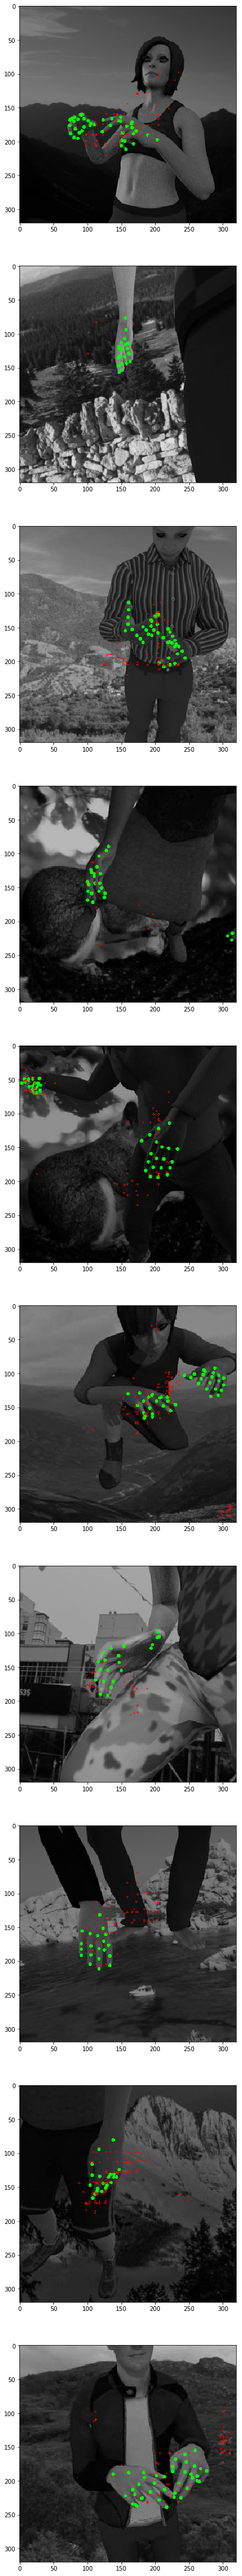

In [20]:
f, subs = plt.subplots(len(images_show), 1, figsize=(15, 8*len(samples_to_check)))
for c, im in enumerate(images_show):
    subs[c].imshow(im)
    #subs[c].set_title(f"Confidence: {np.max(res[c][:,:,:,0])}")

#f = plt.figure(figsize=(20, 20))
#plt.imshow(images_show[0], cmap='gray')